# Set up in Google Colab

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
%cd "/content/drive/MyDrive/Colab Notebooks"

In [ ]:
!pip install quantile-forest

In [ ]:
!pip install -i https://test.pypi.org/simple/ drf==0.1

In [5]:
!Rscript -e "dir.create('/content/drive/MyDrive/Rlibs', showWarnings = FALSE); \
             .libPaths(c('/content/drive/MyDrive/Rlibs', .libPaths())); \
             if (!requireNamespace('drf', quietly = TRUE)) \
                 install.packages('drf', lib='/content/drive/MyDrive/Rlibs', repos='https://cloud.r-project.org'); \
             library(drf); \
             print(packageVersion('drf'))"

[1] ‘1.1.0’


In [6]:
import rpy2.robjects as ro
ro.r('.libPaths(c("/content/drive/MyDrive/Rlibs", .libPaths()))')

from drf import drf

# Basic imports

In [1]:
import os
os.environ['KMP_DUPLICATE_LIB_OK'] = 'TRUE'
# os.environ['OMP_NUM_THREADS'] = '8'
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import sys
sys.path.append('../')
from joblib import Parallel, delayed
from sklearn.metrics import mean_pinball_loss
from scipy.stats import gaussian_kde
import seaborn as sns
sns.set_style('darkgrid')
# %load_ext autoreload
# %autoreload 2

In [2]:
from src.qmem import QMEM, quantile, energy_distance
from src import tqf

In [ ]:
from scipy import special

def mean_distance_in_ellipse(a: float, b: float):
    """
    Return expectation value of the Euclidean distance between two points
    sampled independently and uniformly from an elliptical disk
    x^2/a^2 + y^2/b^2 <= 1 

    Parameters
    ----------
    a, b : float
        radius of an ellipse
    """
    A = float(max(a, b))
    B = float(min(a, b))

    assert A > 0. and B > 0.
    e2 = 1.0 - (B / A) ** 2
    E = special.ellipe(e2)

    return (256.0 * A / (45.0 * np.pi ** 2)) * E

# Dataset preparation

In [4]:
radius_1, radius_2 = 1.0, 1.0

def uni(n: int, seed: int):
    """
    Generate n points randomly inside a unit disk in R^2.
    """
    RNG = np.random.default_rng(seed)
    Z = RNG.standard_normal(size=(n, 2))
    r = np.linalg.norm(Z, axis=1).reshape(-1, 1)
    Z = Z / r * np.exp(- r**2 / 4)

    Z *= np.array([radius_1, radius_2])
    th = np.pi / 4
    Z = Z @ np.array([[np.cos(th), - np.sin(th)], [np.sin(th), np.cos(th)]])

    return Z

avg_interdist = mean_distance_in_ellipse(radius_1, radius_2)

In [5]:
avg_interdist

np.float64(0.9054147873672268)

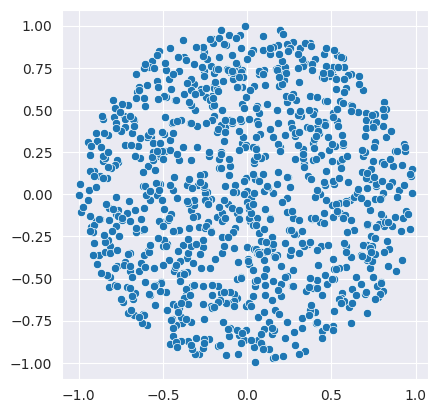

In [ ]:
Z = uni(n=1000, seed=1)
fig, ax = plt.subplots()
sns.scatterplot(x=Z[:, 0], y=Z[:, 1], ax=ax)
ax.set_aspect('equal')

In [6]:
def create_data_on_disk(seed: int, n: int, x: float | None = None) -> tuple:

    RNG = np.random.default_rng(seed)
    factor = 2.0
    if x is None:

        X = RNG.uniform(low=0., high=1., size=n).reshape(-1, 1)
        Y = factor * X + uni(seed=seed, n=n)

        return X, Y

    else:
        Y = factor * x + uni(seed=seed, n=n)

        return Y

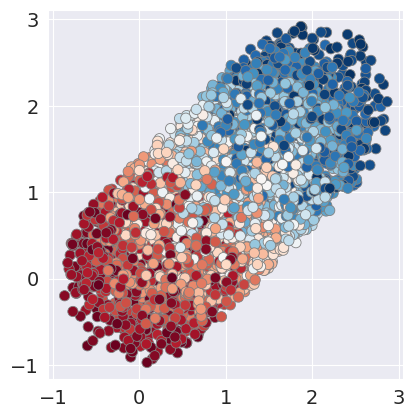

In [ ]:
X_sam, Y_sam = create_data_on_disk(seed=3, n=4000)

fig, ax = plt.subplots()
ax.set_aspect('equal', adjustable='box')
ax.set_xticks([-1,0,1,2,3]); ax.set_yticks([-1,0,1,2,3]); ax.tick_params(labelsize=14)
sns.scatterplot(x=Y_sam[:, 0], y=Y_sam[:, 1], ax=ax, c=X_sam.ravel(), cmap='RdBu', edgecolor='grey', s=55)
# plt.savefig('fg_sliding_circle.pdf', dpi=400)
plt.show()

In [7]:
qs_common = np.linspace(0.05, 0.95, 20)
vs_common = np.array([[np.cos(th), np.sin(th)] for th in np.linspace(0, 2 * np.pi, 21)[:-1]])
qs_common.shape, vs_common.shape

((20,), (20, 2))

# Hyperparameter tuning for TQF

In [ ]:
def sliced_mean_pinball_loss_for_TQF(X_: np.ndarray | pd.DataFrame, Y_: np.ndarray | pd.DataFrame,
                                     vs: np.ndarray | list, qs: np.ndarray | list, model: tqf.TQF) -> float:

    from sklearn.metrics import mean_pinball_loss
    assert model.fitted
    assert X_.ndim == Y_.ndim == 2

    y_preds = model.y_scaler_1d.inverse_transform(
                  model.predict_q(
                      X_long=np.c_[
                          np.tile(X_, (len(vs), 1)),
                          np.repeat([model.expand_v(v=v, n_rot=model.n_rot) for v in vs], len(X_), axis=0)
                      ],
                      qs=qs
                  ).reshape(-1, 1)
              ).reshape(len(X_) * len(vs), len(qs))

    y_trues = np.concatenate([model.y_scaler_whole.transform(Y_) @ v for v in vs])

    return 2 * np.mean([mean_pinball_loss(y_pred=y_preds[:, i], y_true=y_trues, alpha=q) for i, q in enumerate(qs)])

In [ ]:
%%time
model = tqf.TQF(y_scaler_whole=None)
for n_augment in [20]:
    for n_rot in [10]:
        for trff in [0]:
            for msl in [5, 10, 15, 20, 25, 30]:
                ls = []
                for sd in range(30):
                    _X_train, _Y_train = create_data_on_disk(seed=sd, n=30)
                    _X_val, _Y_val = create_data_on_disk(seed=sd + 1000, n=1000)
                    model.fit(X=_X_train, Y=_Y_train, seed=sd, n_augment=n_augment, n_jobs=1, n_rot=n_rot, T_rff=trff,
                              qrf_params={'n_estimators': 10, 'min_samples_leaf': msl})
                    loss_val = sliced_mean_pinball_loss_for_TQF(X_=_X_val, Y_=_Y_val, vs=vs_common,
                                                                qs=qs_common, model=model)
                    ls.append(loss_val)
                print(msl, '\t', np.mean(ls))

5 	 0.3619144050473676
10 	 0.3482596581417562
15 	 0.34432317393199136
20 	 0.3458481975746466
25 	 0.3495301889016484
30 	 0.3550252360139107
CPU times: user 33.3 s, sys: 33.1 ms, total: 33.3 s
Wall time: 34.1 s


In [ ]:
def TQF_fit_and_test(seed: int):

    print(seed, end=' ')
    X_train, Y_train = create_data_on_disk(seed=seed, n=30)
    x_test = np.random.default_rng(seed).uniform(low=0., high=1.)

    model = tqf.TQF(y_scaler_whole=None)
    model.fit(X=X_train, Y=Y_train, seed=seed, n_augment=20, n_jobs=1, n_rot=10, T_rff=0,
              qrf_params={'n_estimators': 10, 'min_samples_leaf': 15})
    out = model.predict(x=np.array([x_test]), seed=seed, n_jobs=5, verbose=False,
                        n_directions=20, n_qs=20, n_ensemble=10, patience=5)
    w_opt, points = out[0], out[1]
    ed = energy_distance(X=points, weight_X=w_opt, Y=create_data_on_disk(seed=seed, n=50000, x=x_test),
                         interdist_Y=avg_interdist)
    gkde = gaussian_kde(points.T, weights=w_opt)
    nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
    if not nll == nll:   # when nll is nan
        nll = np.mean(- np.log([gkde.pdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)]))

    X_test, Y_test = create_data_on_disk(seed=seed, n=1000)
    smpl = sliced_mean_pinball_loss_for_TQF(X_=X_test, Y_=Y_test, vs=vs_common, qs=qs_common, model=model)

    return ed, nll, smpl

In [ ]:
%%time
res_tqf = np.array([TQF_fit_and_test(seed) for seed in range(300)])

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263 264 265 266 267 268 269 270 271 272 273 274 275 276 27

In [ ]:
res_tqf

array([[0.1333708 , 1.51312824, 0.33112677],
       [0.2813962 , 1.65873265, 0.36690041],
       [0.28563975, 1.57231676, 0.33531974],
       [0.22278512, 1.86357169, 0.33830627],
       [0.36755646, 1.86192938, 0.34983828],
       [0.41848121, 2.45712725, 0.36744666],
       [0.3541575 , 5.14954044, 0.35122303],
       [0.30035095, 1.69214642, 0.3340822 ],
       [0.15262239, 1.58684843, 0.3254585 ],
       [0.2010402 , 1.60358441, 0.34263479],
       [0.20064453, 1.53264796, 0.3348465 ],
       [0.13069174, 1.54339193, 0.34913688],
       [0.15792182, 1.56377281, 0.32488178],
       [0.16405248, 1.62413716, 0.35000555],
       [0.12780191, 1.57452033, 0.31787418],
       [0.27673288, 2.35067418, 0.33595647],
       [0.15906366, 1.59081749, 0.33608944],
       [0.19373951, 1.9617729 , 0.3291987 ],
       [0.21365024, 1.66250551, 0.33313811],
       [0.22372085, 1.52954916, 0.3387673 ],
       [0.18961236, 1.89647926, 0.34526852],
       [0.28125579, 1.75121366, 0.34341362],
       [0.

In [ ]:
np.mean(res_tqf, axis=0), np.std(res_tqf, axis=0)

(array([0.28969067, 2.01117181, 0.34240935]),
 array([0.13308307, 0.69165725, 0.01121277]))

In [ ]:
np.save('eval_tqf_result_fewdataregime.npy', res_tqf)

In [79]:
res_tqf = np.load('saved_outputs/eval_tqf_result_fewdataregime.npy')
# res_tqf = np.load('eval_tqf_result_fewdataregime.npy')
res_tqf.shape

(300, 3)

sanity check

In [ ]:
y = np.array([.5, .25, -.7])
NN = 300
np.random.seed(9)
zs = np.random.randn(NN, 3)
vs_3d = np.random.randn(200, 3)
vs_3d /= np.linalg.norm(vs_3d, axis=1).reshape(-1, 1)
_co = lambda d: (d - 1) * np.sqrt(np.pi) * special.gamma((d - 1) / 2) / special.gamma(d / 2)
_co(3) * np.mean([[mean_pinball_loss(y_pred=[np.quantile(zs @ v, q=q)], y_true=[v @ y], alpha=q) for q in np.linspace(0.01, 0.99, 100)]
                 for v in vs_3d])

np.float64(0.6784734168297138)

In [ ]:
from scipy.spatial.distance import pdist
np.mean(np.linalg.norm(y - zs, axis=1))- 0.5 * pdist(zs).mean()

np.float64(0.678309951802408)

In [31]:
%%time
model = tqf.TQF(y_scaler_whole=None)
_X_train, _Y_train = create_data_on_disk(seed=123, n=30)
model.fit(X=_X_train, Y=_Y_train, seed=1, n_augment=20, n_jobs=1, n_rot=10, T_rff=0,
          qrf_params={'n_estimators': 10, 'min_samples_leaf': 15})

CPU times: user 100 ms, sys: 990 µs, total: 101 ms
Wall time: 139 ms


In [32]:
%%time
x_test = 0.3
out = model.predict(x=np.array([x_test]), seed=1, n_jobs=1, n_directions=20, n_qs=20, n_ensemble=10, patience=5)
w_opt, points = out[0], out[1]

Initial search done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Optimization done.
Parallel optimization in progress... Done.
Dropping unnecessary support points... Done.
Number of support points: 705, selection rate: 70.5 %
CPU times: user 2min 13s, sys: 464 ms, total: 2min 13s
Wall time: 1min 25s


In [33]:
%%time
from src.qmem import energy_distance
ed_tqf = energy_distance(X=points, weight_X=w_opt, Y=create_data_on_disk(seed=1, n=50000, x=x_test),
                         interdist_Y=avg_interdist)
ed_tqf

CPU times: user 7.44 s, sys: 15.5 ms, total: 7.46 s
Wall time: 7.44 s


np.float64(0.21853528830849966)

In [34]:
# nll: lower is better
from scipy.stats import gaussian_kde
gkde = gaussian_kde(points.T, weights=w_opt)
nll_tqf = np.array([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=1, n=50000, x=x_test)])
nll_tqf.mean(), nll_tqf.std()

(np.float64(1.5623513443833115), np.float64(0.7016797560459351))

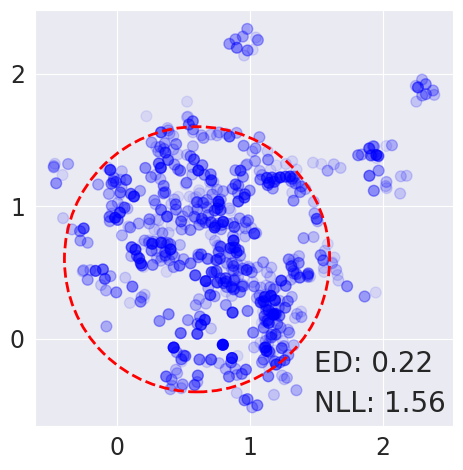

In [73]:
fig, ax = plt.subplots()
plt.scatter(points[:, 0], points[:, 1], alpha=w_opt / np.max(w_opt), s=60, c='b')
ax.set_aspect('equal', adjustable='box')

from matplotlib.patches import Ellipse

center_x = 2 * x_test
center_y = 2 * x_test
ellipse = Ellipse(
    xy=(center_x, center_y),  # 中心座標 (x, y)
    width=radius_1 * 2, height=radius_2 * 2, # angle=-45,
    color='red',           # 色
    fill=False,            # 塗りつぶさない (円周のみ表示)
    linestyle='--',        # 線種を破線に
    linewidth=2,           # 線の太さ
)
ax.add_patch(ellipse)
ax.text(x=1.48, y=-0.25, s="ED: {:.2f}".format(ed_tqf), fontsize=20)
ax.text(x=1.48, y=-0.55, s="NLL: {:.2f}".format(nll_tqf.mean()), fontsize=20)
ax.tick_params(labelsize=17)
ax.set_xticks([0,1,2]); ax.set_yticks([0,1,2])
plt.tight_layout()
# plt.savefig('fg_tqf_circ.pdf', dpi=400)
plt.show()

# Hyperparameter tuning for DRF

In [ ]:
def sliced_mean_pinball_loss_for_DRF(Y_true: np.ndarray | pd.DataFrame, Y_train: np.ndarray | pd.DataFrame, weight_Y: np.ndarray,
                                     vs: np.ndarray | list, qs: np.ndarray | list, n_jobs: int) -> float:

    assert Y_true.ndim == Y_train.ndim == 2
    assert weight_Y.ndim == 2 and weight_Y.shape == (len(Y_true), len(Y_train))

    Y_proj = [(Y_train if isinstance(Y_train, np.ndarray) else Y_train.values) @ v for v in vs]

    def aux(j: int):
        out = []
        for k in range(len(Y_true)):
            out += [quantile(data=Y_proj[j], weight=weight_Y[k], q=qs)]
        return out

    y_preds = Parallel(n_jobs=n_jobs)(delayed(aux)(j) for j in range(len(vs)))
    y_preds = np.concatenate(y_preds)

    y_trues = np.concatenate([Y_true @ v for v in vs])

    return 2 * np.mean([mean_pinball_loss(y_pred=y_preds[:, i], y_true=y_trues, alpha=q) for i, q in enumerate(qs)])

In [ ]:
%%time
loss_lowest = 1e8

for sample_fraction in [0.3, 0.5, 0.7, 0.9]:
    for min_node_size in np.arange(1, 16):

        ls = []
        for sd in range(30):
            _X_train, _Y_train = create_data_on_disk(seed=sd, n=30)
            _X_val, _Y_val = create_data_on_disk(seed=sd + 1000, n=1000)
            DRF = drf(min_node_size=min_node_size, num_trees=10, splitting_rule="FourierMMD", honesty=False, sample_fraction=sample_fraction, ci_group_size=1,
                      compute_oob_predictions=False, seed=sd)
            DRF.fit(_X_train, _Y_train)
            out = DRF.predict(newdata=_X_val)
            loss_val = sliced_mean_pinball_loss_for_DRF(Y_true=_Y_val, Y_train=_Y_train, weight_Y=out.weights,
                                                        vs=vs_common, qs=qs_common, n_jobs=1)
            ls.append(loss_val)

        signal = ''
        if loss_lowest > np.mean(ls):
            loss_lowest = np.mean(ls)
            signal = '*'

        print(sample_fraction, min_node_size, '\t', np.mean(ls), '\t', signal)

0.3 1 	 0.3576168285633249 	 *
0.3 2 	 0.35692160466154627 	 *
0.3 3 	 0.3571397445338639 	 
0.3 4 	 0.35402475093086955 	 *
0.3 5 	 0.3540406976074949 	 
0.3 6 	 0.35975283788279877 	 
0.3 7 	 0.3607557113245171 	 
0.3 8 	 0.3608245743410785 	 
0.3 9 	 0.4655409887255686 	 
0.3 10 	 0.4664506569865592 	 
0.3 11 	 0.46564240719426964 	 
0.3 12 	 0.4652244034857631 	 
0.3 13 	 0.4653814845956109 	 
0.3 14 	 0.46583706842553857 	 
0.3 15 	 0.4655167274131501 	 
0.5 1 	 0.36302091217681437 	 
0.5 2 	 0.3626912544157247 	 
0.5 3 	 0.3627463383459292 	 
0.5 4 	 0.3567730322009897 	 
0.5 5 	 0.3530538561986099 	 *
0.5 6 	 0.3477780147341456 	 *
0.5 7 	 0.3463098162881053 	 *
0.5 8 	 0.34701694108774056 	 
0.5 9 	 0.34826666852900334 	 
0.5 10 	 0.3528737479971112 	 
0.5 11 	 0.35313076662138065 	 
0.5 12 	 0.35800201148081007 	 
0.5 13 	 0.3575654240859623 	 
0.5 14 	 0.3580331622546716 	 
0.5 15 	 0.4634800795841897 	 
0.7 1 	 0.37893926065565176 	 
0.7 2 	 0.3786264906344694 	 
0.7 3 	 0.3

In [ ]:
%%time
loss_lowest = 1e8

for sample_fraction in [0.3, 0.5, 0.7, 0.9]:
    for min_node_size in np.arange(1, 16):

        ls = []
        for sd in range(30):
            _X_train, _Y_train = create_data_on_disk(seed=sd, n=30)
            _X_val, _Y_val = create_data_on_disk(seed=sd + 1000, n=1000)
            DRF = drf(min_node_size=min_node_size, num_trees=10, splitting_rule="FourierMMD", honesty=True, sample_fraction=sample_fraction, ci_group_size=1,
                      compute_oob_predictions=False, seed=sd)
            DRF.fit(_X_train, _Y_train)
            out = DRF.predict(newdata=_X_val)
            loss_val = sliced_mean_pinball_loss_for_DRF(Y_true=_Y_val, Y_train=_Y_train, weight_Y=out.weights,
                                                        vs=vs_common, qs=qs_common, n_jobs=1)
            ls.append(loss_val)

        signal = ''
        if loss_lowest > np.mean(ls):
            loss_lowest = np.mean(ls)
            signal = '*'

        print(sample_fraction, min_node_size, '\t', np.mean(ls), '\t', signal)

0.3 1 	 0.38395729135293716 	 *
0.3 2 	 0.38318180777137467 	 *
0.3 3 	 0.385023687161757 	 
0.3 4 	 0.3846156846882865 	 
0.3 5 	 0.4728005672390402 	 
0.3 6 	 0.47267486742715553 	 
0.3 7 	 0.4725790343996483 	 
0.3 8 	 0.4727405929782393 	 
0.3 9 	 0.4734671739423582 	 
0.3 10 	 0.4726222558570989 	 
0.3 11 	 0.47362125530352156 	 
0.3 12 	 0.4739695369461822 	 
0.3 13 	 0.4740299199517424 	 
0.3 14 	 0.4730982663510928 	 
0.3 15 	 0.4729846951726083 	 
0.5 1 	 0.3525534766818929 	 *
0.5 2 	 0.35248135772943795 	 *
0.5 3 	 0.3527075553959544 	 
0.5 4 	 0.3611481792880186 	 
0.5 5 	 0.3625134049739493 	 
0.5 6 	 0.3670503556619965 	 
0.5 7 	 0.3661011216789699 	 
0.5 8 	 0.46609494674202007 	 
0.5 9 	 0.4655465001230851 	 
0.5 10 	 0.4658686906971646 	 
0.5 11 	 0.46682799608020625 	 
0.5 12 	 0.46585684544819195 	 
0.5 13 	 0.46570697848151077 	 
0.5 14 	 0.466812360006972 	 
0.5 15 	 0.46584438460227384 	 
0.7 1 	 0.34771412021956877 	 *
0.7 2 	 0.3475592883379947 	 *
0.7 3 	 0.347

In [ ]:
def DRF_fit_and_test(seed: int):

    X_train, Y_train = create_data_on_disk(seed=seed, n=30)
    x_test = np.random.default_rng(seed).uniform(low=0., high=1.)

    model = drf(min_node_size=4, honesty=True, sample_fraction=0.7, num_trees=10, ci_group_size=1,
                splitting_rule="FourierMMD", compute_oob_predictions=False, seed=seed)
    model.fit(X_train, Y_train)
    w_drf = model.predict(np.array([[x_test]])).weights.ravel()
    ed = energy_distance(X=Y_train, Y=create_data_on_disk(seed=seed, n=50000, x=x_test),
                         weight_X=w_drf, interdist_Y=avg_interdist)
    gkde = gaussian_kde(Y_train.T, weights=w_drf)
    nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
    if not nll == nll:   # when nll is nan
        nll = np.mean(- np.log([gkde.pdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)]))

    X_test, Y_test = create_data_on_disk(seed=seed, n=1000)
    out = model.predict(X_test)
    smpl = sliced_mean_pinball_loss_for_DRF(Y_true=Y_test, Y_train=Y_train, weight_Y=out.weights,
                                            vs=vs_common, qs=qs_common, n_jobs=1)

    return ed, nll, smpl

In [ ]:
%%time
res_drf = np.array([DRF_fit_and_test(seed) for seed in range(300)])

/tmp/ipython-input-2681269239.py:13: RuntimeWarning: Mean of empty slice
  nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
/tmp/ipython-input-2681269239.py:13: RuntimeWarning: Mean of empty slice
  nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
/tmp/ipython-input-2681269239.py:13: RuntimeWarning: Mean of empty slice
  nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
/tmp/ipython-input-2681269239.py:13: RuntimeWarning: Mean of empty slice
  nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])
/tmp/ipython-input-2681269239.py:13: RuntimeWarning: Mean of empty slice
  nll = np.nanmean([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=seed, n=10000, x=x_test)])


CPU times: user 15min 55s, sys: 1.57 s, total: 15min 56s
Wall time: 10min 37s


In [ ]:
res_drf

array([[0.36106413, 1.83472785, 0.33749083],
       [0.32102736, 1.74645698, 0.38918421],
       [0.66786803, 2.54524319, 0.34163185],
       [0.26191776, 1.58413402, 0.32942206],
       [0.3765441 , 2.16711966, 0.36053207],
       [0.45368085, 1.793119  , 0.34389197],
       [0.34637223, 1.65289589, 0.33940927],
       [0.47536964, 1.92865805, 0.34274825],
       [0.19895601, 1.58274867, 0.34632607],
       [0.33145891, 1.76715817, 0.36705297],
       [0.3034049 , 1.70300579, 0.3336027 ],
       [0.367115  , 2.01525886, 0.34799906],
       [0.27192201, 1.84909185, 0.33284615],
       [0.27242255, 1.59315558, 0.36146543],
       [0.22239087, 1.71314559, 0.34168285],
       [0.26432498, 1.68796528, 0.34190481],
       [0.22207477, 1.68430904, 0.34671903],
       [0.32828921, 1.74261215, 0.33460556],
       [0.29573897, 1.75184523, 0.34549704],
       [0.39120475, 1.81377811, 0.33918139],
       [0.34541576, 1.83622868, 0.36402667],
       [0.32780009, 1.73075025, 0.35175758],
       [0.

In [ ]:
np.mean(res_drf, axis=0), np.std(res_drf, axis=0)

(array([0.3449421 , 1.86082062, 0.34629444]),
 array([0.10939245, 0.25774485, 0.01321178]))

In [ ]:
np.save('eval_drf_result_fewdataregime.npy', res_drf)

In [80]:
res_drf = np.load('saved_outputs/eval_drf_result_fewdataregime.npy')
res_drf.shape

(300, 3)

In [36]:
x_test = 0.3

model = drf(min_node_size=4, honesty=True, sample_fraction=0.7, num_trees=10, ci_group_size=1,
            splitting_rule="FourierMMD", compute_oob_predictions=False, seed=0)
_X_train, _Y_train = create_data_on_disk(seed=123, n=30)
model.fit(_X_train, _Y_train)
w_drf = model.predict(np.array([[x_test]])).weights.ravel()

In [37]:
np.round(w_drf / w_drf.max(), 2)

array([0.  , 0.  , 0.  , 0.22, 0.  , 0.  , 0.  , 0.98, 0.  , 0.  , 0.54,
       1.  , 0.  , 0.22, 0.1 , 0.1 , 0.  , 0.  , 0.  , 0.65, 0.22, 0.  ,
       0.98, 0.56, 0.  , 0.  , 0.78, 0.1 , 0.  , 0.22])

In [39]:
%%time
from src.qmem import energy_distance
ed_drf = energy_distance(X=_Y_train, weight_X=w_drf, Y=create_data_on_disk(seed=1, n=50000, x=x_test),
                         interdist_Y=avg_interdist)
ed_drf

CPU times: user 525 ms, sys: 999 µs, total: 526 ms
Wall time: 1.91 s


np.float64(0.37243934404157364)

In [17]:
# nll: lower is better
from scipy.stats import gaussian_kde
gkde = gaussian_kde(_Y_train.T, weights=w_drf)
nll_drf = np.array([- gkde.logpdf(y).item() for y in create_data_on_disk(seed=1, n=50000, x=x_test)])
nll_drf.mean(), nll_drf.std()

(np.float64(1.8802565623097984), np.float64(0.9405556821136062))

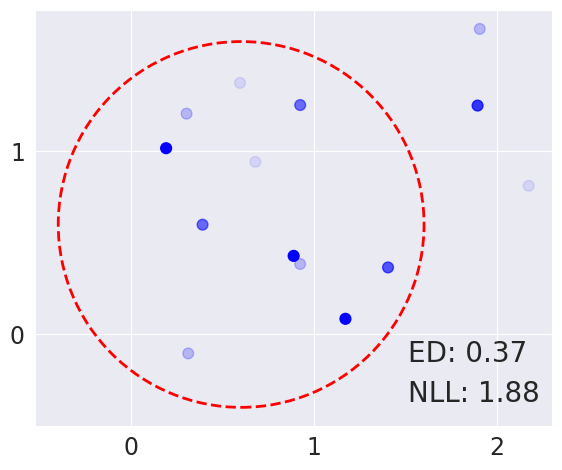

In [67]:
fig, ax = plt.subplots()
didx = w_drf > 0.
plt.scatter(_Y_train[didx, 0], _Y_train[didx, 1], alpha=w_drf[didx] / np.max(w_drf[didx]), s=60, c='b')
ax.set_aspect('equal', adjustable='box')

from matplotlib.patches import Ellipse

center_x = 2 * x_test
center_y = 2 * x_test
ellipse = Ellipse(
    xy=(center_x, center_y),  # 中心座標 (x, y)
    width=radius_1 * 2, height=radius_2 * 2, # angle=-45,
    color='red',           # 色
    fill=False,            # 塗りつぶさない (円周のみ表示)
    linestyle='--',        # 線種を破線に
    linewidth=2,           # 線の太さ
)
ax.add_patch(ellipse)
ax.text(x=1.51, y=-0.15, s="ED: {:.2f}".format(ed_drf), fontsize=20)
ax.text(x=1.51, y=-0.37, s="NLL: {:.2f}".format(nll_drf.mean()), fontsize=20)
ax.tick_params(labelsize=17)
ax.set_xticks([0,1,2]); ax.set_yticks([0,1])
plt.tight_layout()
# plt.savefig('fg_drf_circ.pdf', dpi=400)
plt.show()

# Statistical analysis

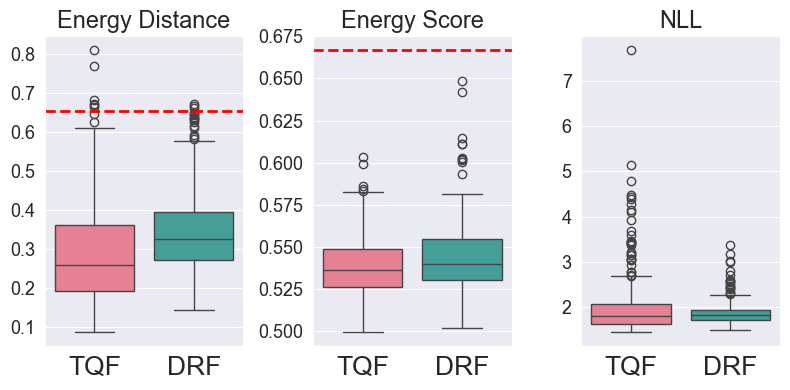

In [ ]:
coef = lambda d: (d - 1) * 0.5 * np.sqrt(np.pi) * special.gamma((d - 1) / 2) / special.gamma(d / 2)

fig, ax = plt.subplots(1, 3, figsize=(8, 4))
sns.boxplot(data=[res_tqf[:, 0], res_drf[:, 0]], ax=ax[0], palette='husl')
sns.boxplot(data=[res_tqf[:, 1], res_drf[:, 1]], ax=ax[2], palette='husl')
sns.boxplot(data=[res_tqf[:, 2] * coef(2), res_drf[:, 2] * coef(2)], ax=ax[1], palette='husl')
for i, ax_ in enumerate(ax):
    ax_.set_xticks([0, 1])
    ax_.tick_params(labelsize=13)
    ax_.set_xticklabels(['TQF', 'DRF'], fontsize=19)
    ax_.set_title(['Energy Distance', 'Energy Score', 'NLL'][i], fontsize=17)

ax[0].axhline((4/3 - avg_interdist) ** 0.5, 0, 1, c='r', ls='--', lw=2)
ax[1].axhline(2/3, 0, 1, c='r', ls='--', lw=2)

plt.tight_layout()
# plt.savefig('fg_boxplot.pdf', dpi=400)
plt.show()

In [ ]:
(np.mean(res_tqf[:, 0]), np.std(res_tqf[:, 0])), \
    (np.mean(res_tqf[:, 2]) * coef(2), np.std(res_tqf[:, 2]) * coef(2)), \
        (np.mean(res_tqf[:, 1]), np.std(res_tqf[:, 1]))

((np.float64(0.2896906706170647), np.float64(0.1330830728272848)),
 (np.float64(0.5378553455901108), np.float64(0.017612983751445658)),
 (np.float64(2.0111718054564793), np.float64(0.691657249415313)))

In [ ]:
(np.mean(res_drf[:, 0]), np.std(res_drf[:, 0])), \
    (np.mean(res_drf[:, 2]) * coef(2), np.std(res_drf[:, 2]) * coef(2)), \
        (np.mean(res_drf[:, 1]), np.std(res_drf[:, 1]))

((np.float64(0.3449421001216999), np.float64(0.109392445100516)),
 (np.float64(0.5439580270287262), np.float64(0.020753019977047815)),
 (np.float64(1.8608206246283612), np.float64(0.2577448527429584)))

In [ ]:
from scipy.stats import shapiro
# The Shapiro-Wilk test for normality
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.shapiro.html

shapiro(res_tqf[:, 0]), shapiro(res_tqf[:, 1]), shapiro(res_tqf[:, 2]), \
    shapiro(res_drf[:, 0]), shapiro(res_drf[:, 1]), shapiro(res_drf[:, 2])

(ShapiroResult(statistic=np.float64(0.905956576612538), pvalue=np.float64(9.877254802100717e-13)),
 ShapiroResult(statistic=np.float64(0.6438577293460657), pvalue=np.float64(1.4670348448810377e-24)),
 ShapiroResult(statistic=np.float64(0.9716852508964634), pvalue=np.float64(1.2295727353180147e-05)),
 ShapiroResult(statistic=np.float64(0.9355248201903247), pvalue=np.float64(3.8707408602254117e-10)),
 ShapiroResult(statistic=np.float64(0.7954544442175885), pvalue=np.float64(3.994579998706527e-19)),
 ShapiroResult(statistic=np.float64(0.9080653969602582), pvalue=np.float64(1.4450197897412353e-12)))

In [ ]:
from scipy.stats import wilcoxon
# The Wilcoxon signed-rank test (two-sided)
# https://docs.scipy.org/doc/scipy/reference/generated/scipy.stats.wilcoxon.html

for i in [0, 2, 1]:
    print(i, wilcoxon(x=res_tqf[:, i], y=res_drf[:, i]))

0 WilcoxonResult(statistic=np.float64(11441.0), pvalue=np.float64(1.3198437636586534e-13))
2 WilcoxonResult(statistic=np.float64(15331.0), pvalue=np.float64(1.4551982285190453e-06))
1 WilcoxonResult(statistic=np.float64(20799.0), pvalue=np.float64(0.2375837390908616))


# Point prediction

In [77]:
x_test = 0.3
energy_distance(X=np.array([[2 * x_test, 2 * x_test]]), 
                Y=create_data_on_disk(seed=1, n=100000, x=x_test),
                interdist_Y=avg_interdist)

np.float64(0.655943104944732)

In [73]:
(4/3 - avg_interdist) ** 0.5

np.float64(0.6541548333277882)